## Imports

In [1]:
import numpy as np

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from numpy.linalg import norm
from numpy.random import normal
from copy import copy
from scipy import stats

from sklearn.datasets import load_wine

## Data

In [2]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)
    
    return X , y

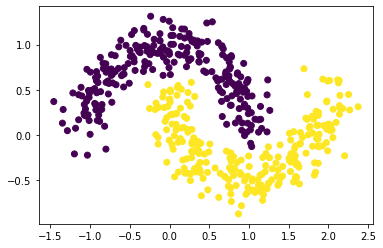

In [3]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

## Classifiers

In [5]:
rd_model = RandomForestClassifier(max_depth=5)
rd_model.fit(X_train,y_train)

knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train,y_train)

svm_model = SVC(kernel='poly')
svm_model.fit(X_train,y_train)

SVC(kernel='poly')

## Generation of counterfactual examples

In [6]:
def uniform_in_sphere(x,n_samples,a_0,a_1):
    d = x.shape[0]
    # sample from gaussian distribution 
    samples = normal(0,1,(n_samples,d))
    
    # normalization
    samples_norm = samples / norm(samples,axis=1).reshape(-1,1)
    # sample from uniform distribution 
    u = np.random.uniform(a_0**d,a_1**d,1) ** (1/d)
    
    return x + samples_norm * u
    

def algorithme_gs_generation(model,sample,eta,n_samples):

    generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
    
    prediction_samples_sph = model.predict(generated_samples_sph)

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() != 0:
        
        eta = eta / 2
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
    a_0 = eta
    a_1 = 2*eta
    
    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)),1,0).sum() == 0:
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,a_0,a_1)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
        a_0 = a_1
        a_1 = a_1 + eta
        
    prediction_samples_sph = model.predict(generated_samples_sph)
    samples_diff_class = generated_samples_sph[np.where(prediction_samples_sph != model.predict(sample.reshape(1,-1)))]
    
    enemy_ind = np.argmin(norm(np.array(samples_diff_class) - np.array(sample),axis=1))

    return samples_diff_class[enemy_ind]


def algorithme_gs_feature_selection(model,sample,enemy):

    enemy_prime = copy(enemy)
    relevant_dimensions = []

    while model.predict(sample.reshape(1,-1)) != model.predict(enemy_prime.reshape(1,-1)):

        enemy_star = copy(enemy_prime)
        
        # extraire uniquement les dimensions differentes
        indices_diffe_dim = np.where(enemy_prime != sample)[0]

        indi = indices_diffe_dim[np.argmin(enemy_prime[indices_diffe_dim] - sample[indices_diffe_dim])]
        
        relevant_dimensions.append(indi)
        
        enemy_prime[indi] = sample[indi]
        

    return enemy_star , relevant_dimensions


def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):
   
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='red', marker='o', s=50, label='Sample')
        plt.scatter(contrf[0], contrf[1], c='green', marker='X', s=50, label=title)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()
    
    
def relevance(model,sample,enemy_star,proxy_thresh=0.8,verbose=False):
    # we will define a new metric for the relevance based on four criteria
    # if one criteria is satisfied : 25%
    # if two criteria is satisfied : 50%
    # if three criteria is satisfied : 75%
    # if all(four) criteria is satisfied : 100%
    
    # threshold for proximity between sample and his counterfactual
    thresh = proxy_thresh
        
    criteria_satf = 0
    va = False
    fea = False
    spar = False
    pro  = False
    
    
    # validity
    if model.predict(sample.reshape(1,-1)) != model.predict(enemy_star.reshape(1,-1)):
        va = True
        criteria_satf += 1
    
    # proximity
    if norm(sample - enemy_star) < thresh:
        pro = True
        criteria_satf += 1
        
    # sparseness 
    # if we keep at least one feature between the sample and his counterfactual 
    if np.where(sample == enemy_star,1,0).sum() != 0 :
        spar = True
        criteria_satf += 1
        
    # feasibility
    
    # Kolmogorov-Smirnov test
    statistic, p_value = stats.ks_2samp(X_train.ravel(), enemy_star.reshape(1,-1).ravel())

    # Significance threshold
    alpha = 0.05

    if p_value >= alpha:
        # the counterfactual sample follows the same distribution as the data
        fea = True
        criteria_satf += 1

    
    if verbose:
        print(f"Validity {va} , Proximity {pro} , Sparseness {spar} , Feasibility {fea}")
    
    return int( (criteria_satf / 4)*100 )
    

## Visualisation

Sample  : 
[0.0182463  1.10094733]


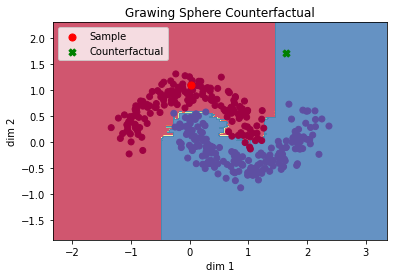

Counterfactual : 
[1.63864454 1.70850939]


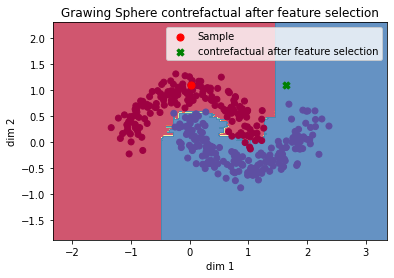

Counterfactual after feature selection
[1.63864454 1.10094733]


In [13]:
sample = X_train[1]
print("Sample  : ")
print(sample)

enemy = algorithme_gs_generation(rd_model,sample,eta=5,n_samples=10)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy)
print("Counterfactual : ")
print(enemy)

enemy_star , _ = algorithme_gs_feature_selection(rd_model,sample,enemy)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy_star,"contrefactual after feature selection")
print("Counterfactual after feature selection")
print(enemy_star)

## Experimentations

#### 1- Study of the stability 
We are going to study the stability of the algorithm and its effect on random variances using two metrics: standard deviation and variance.

#### 2- Study relevance criteria  
We will determine what criteria or metrics we will use to assess the relevance of counterfactual examples.
This could include measures of : **validity , proximity , sparseness , feasibility .** 
We will introduce a novel relevance metric comprising four criteria:
- If one criterion is met: 25%
- If two criteria are met: 50%
- If three criteria are met: 75%
- If all four criteria are met: 100%

#### 3- Define the factors to be studied
The factors we can study are : the stability of the algorithm with respect to its random component, the variation of the data to be explained, the choice of classifier, and the parameters of the Growing Spheres algorithm(eta).

In [14]:
models  = [rd_model , knn_model , svm_model]
samples = [X_train[1] , X_train[13] , X_train[96] ]
eta_s = [ 5 , 10 , 15]

#### Study of the stability

In [17]:
# init
sample = samples[1]
enemies = []

liste_std = []
liste_var = []

for model,eta in zip(models,eta_s):

    for _ in range(10):

        # growing sphere - sphere generation 
        enemy = algorithme_gs_generation(model,sample,eta,n_samples=10)
        # growing sphere - features selection 
        enemy_star, _  = algorithme_gs_feature_selection(model,sample,enemy)

        enemies.append(enemy_star)

    liste_std.append(np.std(enemies))
    liste_var.append(np.var(enemies))
      
print(liste_std)
print(f"The average standard deviation : {np.mean(liste_std)}")

print()

print(liste_var)
print(f"The average variance : {np.mean(liste_var)}")

[0.5983521459549322, 0.46604858114257475, 0.39987254839420233]
The average standard deviation : 0.4880910918305698

[0.35802529056887256, 0.2172012799850071, 0.1598980549592737]
The average variance : 0.24504154183771779


We can see following to results in the experimentations that : 
- The **variance** and the **standard deviation** are relatively close to **zero**.
- the results are coherent and not very sensitive to random variations, showing that the results are tightly clustered around a central value, which is a sign of **stability**.

#### Impact of the classifier on relevance criteria

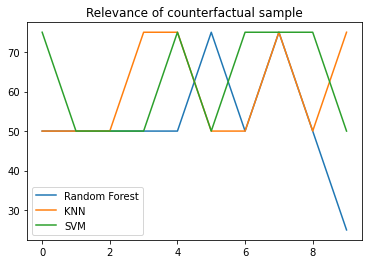

The average relevance for random forest  : 52.5%
The average relevance for knn  : 60.0%
The average relevance for svm  : 62.5%


In [15]:
samples = [X_train[0] , X_train[23] ,X_train[10] , X_train[45] ,X_train[96]]
relevances=  [[],[],[]]
eta = 5 

for sample in X_train[:10]:
    
    for i in range(3):

        # growing sphere - sphere generation 
        enemy = algorithme_gs_generation(models[i],sample,eta,n_samples=10)
        # growing sphere - features selection 
        enemy_star, _ = algorithme_gs_feature_selection(models[i],sample,enemy)

        relevances[i].append(relevance(models[i],sample,enemy_star,False))
        
plt.plot(relevances[0])
plt.plot(relevances[1])
plt.plot(relevances[2])
plt.legend(["Random Forest","KNN","SVM"])
plt.title("Relevance of counterfactual sample")
plt.show()

print(f"The average relevance for random forest  : {np.mean(relevances[0])}%")
print(f"The average relevance for knn  : {np.mean(relevances[1])}%")
print(f"The average relevance for svm  : {np.mean(relevances[2])}%")

We observe that the average relevance rate of the generated counterfactual examples is nearly the same since all three classifiers have almost the same decision boundary and exhibit similar behavior on data that is not too noisy.

#### Impact of eta

[57.0, 56.625, 56.25, 56.3125, 56.6]


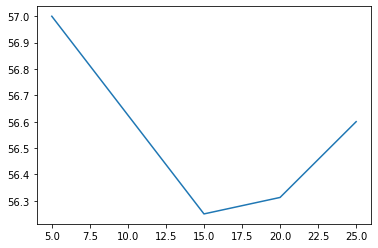

In [16]:
eta_s = [5,10,15,20,25]
relevances = [] 
rele = []
for eta in eta_s:

    for sample in X_train[:100]:
    
        # growing sphere - sphere generation 
        enemy = algorithme_gs_generation(models[0],sample,eta,n_samples=10)
        # growing sphere - features selection 
        enemy_star , _ = algorithme_gs_feature_selection(models[0],sample,enemy)

        rele.append(relevance(models[0],sample,enemy_star,False))
    
    relevances.append(np.mean(rele))
    
print(relevances)
plt.plot(eta_s,relevances)

We ae noting that, irrespective of the eta, the generation of the counterfactual example consistently exhibits a high level of relevance, averaging around 65%.

## Experimentations on real data

### set of samples

We will use the sklearn datatset : Wine

In [65]:
# Load the Wine dataset
wine_data = load_wine()

# Access the features and target variables
X = wine_data.data  # Features
y = wine_data.target  # Target variable

feature_names = np.array(wine_data.feature_names)
target_names = wine_data.target_names
dataset_description = wine_data.DESCR

In [18]:
random_forest = RandomForestClassifier(max_depth=5)
random_forest.fit(X,y)

RandomForestClassifier(max_depth=5)

In an effort to predict which features are non-essential when considering a class change in the case of wine, for each counterfactual example, we will examine which dimension has remained unchanged between it and the original example. We will then create a histogram to visualize which dimension has had minimal impact on the wine's class changes.

In [25]:
proxi_thresh = 6
relevances = []
dims = []

for sample in X[:100]:

    enemy = algorithme_gs_generation(random_forest,sample,eta=6,n_samples=10)

    enemy_star , relevant_dimensions = algorithme_gs_feature_selection(random_forest,sample,enemy)
    
    relevances.append(relevance(random_forest,sample,enemy_star,proxi_thresh,False))
    
    dims.extend(relevant_dimensions)

print(f"The average relevance {np.mean(relevances)}")

The average relevance 59.0


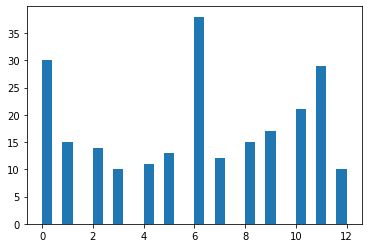

In [26]:
plt.hist(dims,bins=30)
plt.show()

- You will observe that features 0(alcohol) and 6(flavanoids) are not crucial if you intend to transition between classes, but it is advisable to pay closer attention to features 7(nonflavanoid_phenols), 2(ash), and 8(proanthocyanins).
- It's also noticeable that the features **alcohol** and **flavanoids** are common to all wines, so they may not play a significant role in distinguishing between wine classes. Instead, it's advisable to focus on more specific characteristics such as **ash** and **proanthocyanins** 

We can therefore conclude that the Growing Spheres algorithm has enabled us to discover explanations for class changes among the wines. This suggests that the generated counterfactual examples are quite relevant, achieving a score of 58%.

### unique sample

In [60]:
sample = X[100]
enemy = algorithme_gs_generation(random_forest,sample,eta=6,n_samples=10)

enemy_star , relevant_dimensions = algorithme_gs_feature_selection(random_forest,sample,enemy)

relevant_dimensions

[11, 6, 12, 5, 10, 7, 8, 2]

In [62]:
relevance(random_forest,sample,enemy_star,proxi_thresh,True)

Validity True , Proximity False , Sparseness True , Feasibility False


50

In [73]:
not_relevant_featu = feature_names[relevant_dimensions]
print("Features that are not contributed to sample classification")
not_relevant_featu

Features that are not contributed to sample classification


array(['od280/od315_of_diluted_wines', 'flavanoids', 'proline',
       'total_phenols', 'hue', 'nonflavanoid_phenols', 'proanthocyanins',
       'ash'], dtype='<U28')

In this example, an explanation is provided regarding the class membership of the sample :  detailing the features that have contributed to its classification **( 'alcohol', 'malic_acid', 'alcalinity_of_ash', 'magnesium','color_intensity' )**